# Machine learning example

In this notebook I will show all of the machine learning steps that are necessary for simulation based metabolic flux inference.

### Generating our dataset

In [1]:
from sbmfi.models.small_models import spiro, multi_modal
from sbmfi.core.simulator import DataSetSim
from sbmfi.inference.priors import UniNetFluxPrior

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In the cell below, we create the spiro model. We also automatically create a simulator that simulates labelling for 2 different labelling states named `'A'` and `'B'`. The simulator includes a boundary observation model for the boundary fluxes `['bm', 'd_out', 'h_out']` with errors drawn from a multivariate Gaussian. Note that in this incarnation of the model, we do not check whether the noisy boundary fluxes lie in the flux polytope.

In [2]:
model, kwargs = spiro(
    backend='torch',
    auto_diff=False,
    batch_size=1,
    add_biomass=True,
    v2_reversible=True,
    ratios=True,
    build_simulator=True,
    add_cofactors=True,
    which_measurements='lcms',
    seed=2,
    measured_boundary_fluxes = ('h_out', ),
    which_labellings=['A', 'B'],
    include_bom=True,
    v5_reversible=False,
    n_obs=0,
    kernel_basis='svd',
    basis_coordinates='rounded',
    logit_xch_fluxes=False,
    L_12_omega = 1.0,
    clip_min=None,
    transformation='ilr',
)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-27


C:\python_projects\sbmfi\venv\lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


Displayed below are the reactions of the model

In [3]:
for reaction in model.reactions:
    print(reaction, reaction.bounds)

a_in:  --> A/ab (10.0, 10.0)
d_out: D/abc -->  (0.0, 100.0)
f_out: F/a -->  (0.0, 100.0)
h_out: H/ab -->  (0.0, 100.0)
v1: A/ab --> B/ab (0.0, 100.0)
v2: B/ab ==> E/ab (0.0, 100.0)
v3: B/ab + E/cd --> C/abcd + cof (0.0, 100.0)
v4: E/ab --> H/ab (0.0, 100.0)
v5: F/a + D/bcd <-- C/abcd (-100.0, 0.0)
v6: D/abc --> E/ab + F/c (0.0, 100.0)
v7: F/a + F/b --> H/ab (0.0, 100.0)
bm: 0.3 H/. + 0.6 B/. + 0.5 E/. + 0.1 C/. -->  (0.05, 1.5)
EX_cof: cof -->  (0.0, 1000.0)


These are the measurements that we assume to have access to for both labelling conditions.  

In [4]:
print(f"number of LC-MS signals for labelling condition A: {kwargs['annotation_df']['A'].shape}, and B {kwargs['annotation_df']['B'].shape}")

number of LC-MS signals for labelling condition A: (14, 9), and B (10, 9)


In [86]:
kwargs['substrate_df']

,A/00,A/01,A/10,A/11
A,0.2,0.0,0.0,0.8
B,0.0,1.0,0.0,0.0


In [5]:
kwargs['measurements']

labelling_id         A                                                   \
data_id        ilr_C_0   ilr_C_1  ilr_D_0   ilr_D_1   ilr_H_0   ilr_L_0   
0            -2.029316 -1.868853 -2.29619 -1.680012 -0.174556 -1.611885   

labelling_id                                          B            \
data_id       ilr_L_1   ilr_L_2 ilr_L|[1,2]_0   ilr_C_0   ilr_D_0   
0            -2.14425 -2.907779     -1.470387 -4.533702 -2.677548   

labelling_id                                         BOM       
data_id      ilr_H_{M+Cl}_0  ilr_H_0 ilr_L|[1,2]_0 h_out   bm  
0                  -0.37377 -0.37377     -1.509012   7.6  1.5

In [85]:
kwargs['annotation_df']['A']

,met_id,nC13,adduct_name,mz,rt,sigma,omega,total_I,formula
0,C,0,M-H,157.018955,4.0,0.02,NaN,700000.0,C4H6N4OS
1,C,3,M-H,160.029020,4.0,0.02,NaN,700000.0,C4H6N4OS
2,C,4,M-H,161.032375,4.0,0.02,NaN,700000.0,C4H6N4OS
3,D,0,M-H,37.008374,5.0,0.01,NaN,100000.0,C3H2
4,D,2,M-H,39.015083,5.0,0.01,NaN,100000.0,C3H2
5,D,3,M-H,40.018438,5.0,0.01,NaN,100000.0,C3H2
6,H,0,M-H,25.008374,1.0,0.01,NaN,3000.0,C2H2
7,H,1,M-H,26.011728,1.0,0.01,NaN,3000.0,C2H2
8,L,0,M-H,153.926096,6.0,0.01,NaN,400000.0,C5KNaSH
9,L,1,M-H,154.929450,6.0,0.01,NaN,400000.0,C5KNaSH


In [6]:
kwargs['annotation_df']['B']

,met_id,nC13,adduct_name,mz,rt,sigma,omega,total_I,formula
0,C,0,M-H,157.018955,4.0,0.02,NaN,700000.0,C4H6N4OS
1,C,3,M-H,160.029020,4.0,0.02,NaN,700000.0,C4H6N4OS
2,D,0,M-H,37.008374,5.0,0.01,NaN,100000.0,C3H2
3,D,2,M-H,39.015083,5.0,0.01,NaN,100000.0,C3H2
4,H,0,M-H,25.008374,1.0,0.01,NaN,3000.0,C2H2
5,H,1,M-H,26.011728,1.0,0.01,NaN,3000.0,C2H2
6,H,0,M+Cl,60.985051,1.0,0.03,NaN,2000.0,C2H2
7,H,1,M+Cl,61.988406,1.0,0.03,NaN,2000.0,C2H2
8,"L|[1,2]",0,M-H,136.972776,6.0,0.01,1.0,40000.0,C2H2O7
9,"L|[1,2]",1,M-H,137.976131,6.0,0.01,1.0,40000.0,C2H2O7


we will sample `n` fluxes from a uniform prior and simulate `n_obs=3` observations per sampled flux-vector.

In [7]:
n = 20000

bbs = kwargs['basebayes']
sdf = kwargs['substrate_df']
simulator = DataSetSim(model, sdf, bbs._obmods, bbs._bom, num_processes=3)
prior = UniNetFluxPrior(model, cache_size=n)

In [8]:
theta = prior.sample((n,))

In [9]:
# result = simulator.simulate_set(
#     theta,
#     n_obs=3,
#     fluxes_per_task=None,
#     what='all',
#     break_i=-1,
#     close_pool=True,
#     show_progress=False,
#     save_fluxes=True,
# )

here we save the results

In [10]:
hdf = 'spiro_mdvae_test_NEW.h5'
dataset_id = 'test1'
# simulator.to_hdf(
#     hdf=hdf,
#     result=result,
#     dataset_id=dataset_id,
#     append=True,
#     expectedrows_multiplier=10,
# )

## Representing labelling measurements in a reduced latent space

As a back-of-the-envelope calculation, we can imagine that by LC-MS we can measure around 40 CCM metabolites in *E.coli*. Furthermore, lets imagine that on average we can measure 3 mass isotopomers per metabolite per labelling experiment. If we then do 3 labelling experiments (different substrate labellings), we have a total of `40 * 3 * 3 = 360` numbers to represent the labelling state that we use for inference. 

The first thing that we should notice is that MDVs are an inefficient way of representing labelling data. To represent the labelling state of acetate, `ac`, as an MDV we need three numbers `[ac+0, ac+1, ac+2]`. Since by definition an MDV is a point on a probability simplex, there are actually only 2 degrees of freedom for the acetate MDV, since we know it sums to 1. By applying the isometric log-ratio transform to the MDV, we can represent the labelling state using only 2 real (i.e. $\mathbb{R}$) numbers without any loss of information.

By applying the isometric log-ratio transform to all metabolite MDVs, we can now represent the labelling data with `40 * (3-1) * 3 = 240` numbers, and on top of that, these are uncorrelated real numbers unlike when using the MDV representation.

Another inefficiency is that different metabolites within a labelling experiment carry similar information. For example, Alanine is made from pyruvate and thus has a similar MDV as pyruvate. Differences can occur because of the functioning of the LC-MS. For instance `ala+1` might not be measured whereas `pyr+1` could be or there are vastly different noise levels between the two signals.

Generally, if we try to infer 20 free fluxes across many labelling experiments resulting in hundreds of independent mass isotopomer measurements, we should try to compress the data to roughly 20 dimensions.

Except for labelling measurements, we typically also have access to measurements of some boundary fluxes such as growth rate (i.e. biomass flux) and uptake of substrate / excretion of some fermentation products.

In [11]:
from sbmfi.inference.mdvae import MDVAE_Dataset, ray_train_MDVAE, MDVAE
from sbmfi.core.simulator import _BaseSimulator
from sbmfi.settings import BASE_DIR

import math
import os
import numpy as np
import pandas as pd
from scipy.stats import random_correlation, loguniform

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from torch import nn

import time
import tqdm

create training and validation data-sets

In [54]:
DENOISE = True  # whether to feed denoised data (data without observation model noise added)
INCLUDE_BOM = False # whether to include the boundary fluxes in the VAE compression

if not simulator._la.backend == 'torch':
    raise ValueError
mdvs = simulator.read_hdf(hdf=hdf, dataset_id=dataset_id, what='mdv') if DENOISE else None
data = simulator.read_hdf(hdf=hdf, dataset_id=dataset_id, what='data')
theta = simulator.read_hdf(hdf=hdf, dataset_id=dataset_id, what='theta')
mu = simulator.simulate(theta=theta, mdvs=mdvs, n_obs=0) if DENOISE else None

# here we check whether there are any data-dimensions that are independent of fluxes; these should be removed because otherwise the denoising MDVAE does not work (dividing by 0 std leads to inf values)
unchanging = mu[:, 0].std(0) < 1e-4
if unchanging.any(): 
    print(f'Found unchanging data-dimensions: {simulator.data_id[unchanging.numpy()]}')

# simulator.to_partial_mdvs(mu[:6, 0], pandalize=True)
show_unchanged = pd.DataFrame(mu[:6, 0].numpy(), columns=simulator.data_id).head(6)

mu = mu[..., ~unchanging]
data = data[..., ~unchanging]

if (simulator._bom is not None) and not INCLUDE_BOM:
    mu = mu[..., :-simulator._bomsize] if DENOISE else None
    data = data[..., :-simulator._bomsize]

dataset = MDVAE_Dataset(data, mu, standardize=True)

n_validate = math.ceil(0.10 * len(dataset))  # 10 % of the data are keps as validation

train_ds, val_ds = random_split(
    dataset,
    lengths=(len(dataset) - n_validate, n_validate),
    generator=simulator._la._BACKEND._rng  # makes sure we get the same split every time
)

torch.save(train_ds, os.path.join(BASE_DIR, 'train_ds.pt'))
torch.save(val_ds, os.path.join(BASE_DIR, 'val_ds.pt'))

show_unchanged

Found unchanging data-dimensions: MultiIndex([('A', 'ilr_L|[1,2]_0')],
           names=['labelling_id', 'data_id'])


labelling_id         A                                                    \
data_id        ilr_C_0   ilr_C_1   ilr_D_0   ilr_D_1   ilr_H_0   ilr_L_0   
0            -2.453021 -1.851268 -2.265873 -1.672927 -0.096587 -1.460492   
1            -1.387195 -1.872452 -1.811312 -1.607224 -0.147543 -1.643416   
2            -2.213013 -1.827697 -2.158950 -1.650500 -0.019291 -1.502059   
3            -2.983445 -1.951624 -2.481334 -1.729819 -0.132344 -1.272767   
4            -1.700105 -1.819539 -1.851914 -1.609829  0.000000 -1.367280   
5            -1.990402 -1.809998 -1.991374 -1.623786  0.000000 -1.443551   

labelling_id                                           B            \
data_id        ilr_L_1   ilr_L_2 ilr_L|[1,2]_0   ilr_C_0   ilr_D_0   
0            -2.103408 -2.967741     -1.470387 -4.322586 -2.927624   
1            -2.128541 -2.906969     -1.470387 -4.011593 -3.192216   
2            -2.031040 -2.923557     -1.470387 -4.291485 -2.981758   
3            -2.129343 -3.020165     -1.470387 -4.321049 -2.829952   
4            -1.842006 -2.812827     -1.470387 -4.021143 -3.156410   
5            -1.954937 -2.879476     -1.470387 -4.147067 -3.082861   

labelling_id                                              BOM            
data_id      ilr_H_{M+Cl}_0   ilr_H_0 ilr_L|[1,2]_0     h_out        bm  
0                 -0.417337 -0.417337     -1.618714  6.852708  0.634260  
1                 -0.377291 -0.377291     -1.862340  6.974587  0.104373  
2                 -0.480785 -0.480785     -1.687896  4.399312  0.622793  
3                 -0.271017 -0.271017     -1.565778  7.970895  0.413358  
4                 -0.670338 -0.670338     -1.702121  5.182423  0.515469  
5                 -0.611366 -0.611366     -1.559966  4.182602  0.509062

Inspecting the data in the cell above we see that `ilr_L|[1,2]_0` in labelling condition `A` is unchanging, and therefore cannot carry useful information about fluxes. This dimension must be removed from the data. 

The observations of the boundary fluxes should lie in or close to the flux polytope projected onto the exchange flux dimensions; we might thus not want to include these as indicated by the `INCLUDE_BOM` flag.

# HERE WE RUN INTO VAE POSTERIOR COLLAPSE


plotting the data

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
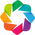

In [67]:
import holoviews as hv
from holoviews.operation import gridmatrix

hv.extension('bokeh')

In [284]:
# n_plot = 10
plot_df = pd.DataFrame(train_ds[:][0][:2000, :n_plot].numpy(), columns=simulator.data_id[~unchanging.numpy()][:n_plot].map('_'.join))

ds = hv.Dataset(plot_df)
grid = gridmatrix(ds, diagonal_type=hv.Scatter)
# grid.opts(shared_axes=False, axiswise=True)

https://medium.com/@ragy202/addressing-posterior-collapse-in-chemical-vaes-151c0f210388

https://arxiv.org/abs/1903.10145

https://medium.com/@david.daeschler/insights-from-developing-a-vae-fbdb2e6ba31f

https://github.com/hubertrybka/vae-annealing

https://arxiv.org/abs/2309.13160

https://arxiv.org/abs/2004.12585

https://arxiv.org/pdf/2310.15440

https://arxiv.org/pdf/1602.02282.pdf

https://www.reddit.com/r/MachineLearning/comments/8wmbof/d_variational_autoencoder_confusion_am_i_wrong/

https://openreview.net/pdf/d8e0df2b7afeaa076f0e448e960df6d5365069c9.pdf

https://towardsdatascience.com/variational-inference-with-normalizing-flows-on-mnist-9258bbcf8810

In [ ]:
from normflows import NormalizingFlowVAE

THIS MIGHT BE GOLDEN!

https://github.com/VincentStimper/normalizing-flows/blob/master/examples/vae.ipynb

Variational auto-encoder

\begin{align*}
\text{ELBO}(x) &= \mathbb{E}_{q_{\phi}(z|x)}[\log p_{\theta}(x|z)] - KL\big[q_{\phi}(z|x) || p(z)\big]
\end{align*}


\begin{align*}
\text{ELBO}(x) &= \mathbb{E}_{q_{\phi}(z|x)}[\log p_{\theta}(x|z)] - KL\big[q_{\phi}(z|x) || f(z)\big]
\end{align*}


$\mathbb{E}_{q_{\phi}(z|x)}[-\frac{1}{2} \sum_{i=1}^D (x_i - \hat{x}_i)^2 / \sigma^2 - \frac{D}{2} \log(2\pi\sigma^2)]$



In [293]:
n_bottleneck = 11
b = torch.tensor(n_bottleneck // 2 * [0, 1] + n_bottleneck % 2 * [0])

b

tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [288]:
n_steps = 1000
steps = np.arange(n_steps)


cyclical_beta = np.vectorize(lambda x: cyclical_annealing(x, n_steps, n_cycles=3, cycle_frac=0.8))(steps)
# hv.Scatter((steps, cyclical_beta))

In [286]:
import math

def linear_annealing(step, n_steps, min_beta=0.0, max_beta=1.0, start_step=0.2, stop_step=0.8):
    if isinstance(start_step, float):
        start_step = math.ceil(start_step * n_steps)

    if isinstance(stop_step, float):
        stop_step = math.floor(stop_step * n_steps)

    if (stop_step < start_step) or (stop_step > n_steps):
        raise ValueError(f'start {start_step}, stop {stop_step}, n {n_steps}')

    if step < start_step:
        return min_beta
    elif step > stop_step:
        return max_beta
    return ((step - start_step) / (stop_step - start_step) * (max_beta - min_beta)) + min_beta

def cyclical_annealing(step, n_steps, min_beta=0.0, max_beta=1.0, n_cycles=4, cycle_frac=0.75, start_step=0.2):
    if isinstance(start_step, float):
        start_step = math.ceil(start_step * n_steps)
    
    if step < start_step:
        return min_beta
    
    n_steps_wup = n_steps - start_step
    
    period = (n_steps_wup/n_cycles) # N_iters/N_cycles 
    internal_period = (step-start_step) % (period)  # Itteration_number/(Global Period)
    tau = internal_period/period
    
    if tau > cycle_frac:
        return max_beta
    else:
        return min(max_beta, max(tau/cycle_frac, min_beta)) # Linear function 


def ray_train_MDVAE(config, cwd, ray=False, show_progress=False):
    # n_epoch = int(config.get('n_epoch', 3))  # previously, ray config would return odd stuff, so I had to specify a type.
    # This is annoying for n_hidden/n_latent, since these can be either int or float
    n_epoch  = int(config.get('n_epoch', 3))
    n_hidden = config.get('n_hidden', 0.6)
    n_latent = config.get('n_latent', 0.3)  # not specifying type
    n_hidden_layers = int(config.get('n_hidden_layers', 2))
    batch_size  = int(config.get('batch_size', 32))
    learning_rate = float(config.get('learning_rate', 1e-4))
    weight_decay  = float(config.get('weight_decay', 1e-4))
    LR_gamma = float(config.get('lr_gamma', 1.0))
    bias = bool(config.get('bias', True))
    mse_reduction = config.get('mse_reduction', 'mean')

    beta_annealing = config.get('beta_annealing', 'constant')
    beta = config.get('beta', 1.0)  # if constant beta
    
    min_beta   = config.get('min_beta',1e-5)
    max_beta   = config.get('max_beta', 1.0)
    start_step = config.get('start_step', 0.15)
    stop_step  = config.get('stop_step', 0.8)

    n_cycles = config.get('n_cycles', 4)
    cycle_frac  = config.get('cycle_frac', 0.75)

    train_ds = torch.load(os.path.join(cwd, 'train_ds.pt'))
    val_ds = torch.load(os.path.join(cwd, 'val_ds.pt'))
    x_val, y_val = val_ds[:]
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    mdvae = MDVAE(
        n_data=x_val.shape[-1],
        n_hidden=n_hidden,
        n_latent=n_latent,
        n_hidden_layers=n_hidden_layers,
        bias=bias,
    )

    loss_f = nn.MSELoss(reduction=mse_reduction)  #
    optimizer = torch.optim.Adam(mdvae.parameters(), lr=learning_rate, weight_decay=weight_decay)
    if LR_gamma < 1.0:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=LR_gamma, last_epoch=-1)

    get_val = lambda x: x.to('cpu').data.numpy().round(4)
    n_steps = n_epoch * len(train_loader)
    if show_progress:
        pbar = tqdm.tqdm(total=n_steps, ncols=100, position=0)

    losses = []

    try:
        
        for epoch in range(n_epoch):
            for i, (x, y) in enumerate(train_loader):
                x_hat, mean, log_var = mdvae.forward(x)
                reconstruct = loss_f(x_hat, y)
                KL_div = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    
                step = i + epoch * len(train_loader)
                if beta_annealing == 'constant':
                    pass
                elif beta_annealing == 'linear':
                    beta = linear_annealing(step, n_steps, min_beta, max_beta, start_step, stop_step)
                elif beta_annealing == 'cyclical':
                    beta = cyclical_annealing(step, n_steps, min_beta, max_beta, n_cycles=4, cycle_frac=0.75)
                else:
                    raise NotImplementedError
                
                loss = reconstruct + beta * KL_div
    
                optimizer.zero_grad()
                if ~(torch.isnan(loss) | torch.isinf(loss)):
                    loss.backward()
                    optimizer.step()
                pbar.update()
                losses.append((0, get_val(loss), get_val(KL_div), get_val(reconstruct), beta))
    
                if ray:
                    raise NotImplemented(' if necessary, still need to implement ray.tune.report')
    
                if (i % 100 == 0) and show_progress:
                    pbar.set_postfix(loss=losses[-1][1].round(4), KL_div=losses[-1][2].round(4), mse=losses[-1][3].round(4), beta=round(beta, 4))
            if LR_gamma < 1.0:
                scheduler.step()
    
            with torch.no_grad():
                x_val_hat, mean, log_var = mdvae.forward(x_val)
                reconstruct = loss_f(x_val_hat, y_val)
                KL_div = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
                loss = reconstruct + beta * KL_div
                losses.append((1, get_val(loss), get_val(KL_div), get_val(reconstruct), beta))
    # try:
    #     pass
    except KeyboardInterrupt:
        pass
    finally:
        losses = pd.DataFrame(losses, columns=['train0_val1', 'loss', 'KL_div', 'mse', 'beta'])
        if show_progress:
            pbar.close()
        return mdvae, losses


In [289]:
N_LATENT = len(simulator.theta_id)  # we assume that the latent dimension equals the number of free fluxes!

mdvae, losses = ray_train_MDVAE({
    'n_epoch': 12,
    'n_hidden':0.7, 
    'n_latent': N_LATENT, 
    'n_hidden_layers': 3, 
    'learning_rate': 3e-4, 
    'batch_size': 32,
    'LR_gamma': 0.9,
    'beta':0.001,
    'beta_annealing': 'constant',
}, cwd=BASE_DIR, show_progress=True)

100%|█████████| 20256/20256 [25:31<00:00, 13.22it/s, KL_div=85.6, beta=0.001, loss=0.236, mse=0.151]


In [169]:
torch.save(mdvae, f'{BASE_DIR}\mdvae_LINANNEAL_hid_lay.p')

In [170]:
losses.to_csv('losses_LINANNEAL_hid_lay.csv')

TODO: make a loss function that looks as follows:  `loss = mse + beta * KL`, but where `beta = 0 if mse>0.2 else KL is ` 

In [282]:
plot_df = losses.loc[losses['train0_val1'] == 0].copy()
plot_df['step'] = np.arange(plot_df.shape[0])
hv.Scatter(plot_df, kdims=['step'], vdims=['loss'])

:Scatter   [step]   (loss)

In [240]:
from IPython.display import display, HTML
HTML("<style>.container { width:100% !important; }</style>")


In [279]:
torch.set_printoptions(linewidth=200)

x_in, y_in = val_ds[[66,12,50]]
with torch.no_grad():
    x_hat, mean, log_var = mdvae.forward(x_in)
print(y_in.round(decimals=4))
print(x_hat.round(decimals=4))
print((y_in -x_hat).round(decimals=4))

tensor([[-1.4888, -0.4535, -1.4076, -1.6278, -1.2023,  0.9095, -0.9654, -1.3648, -0.7778,  0.5750,  0.6824,  0.6824,  0.4209],
        [ 0.0800,  0.5904, -0.0757,  0.4537, -0.6464, -1.3988, -0.6592, -0.2951, -0.5956, -0.1387, -0.1503, -0.1503, -0.8795],
        [-1.7889, -1.0047, -1.7273, -2.3588, -1.5477,  1.5470, -1.0405, -1.6128, -0.6842,  1.1475,  1.6520,  1.6520, -0.3167]])
tensor([[ 0.0013,  0.0026,  0.0055,  0.0071,  0.0112,  0.0083,  0.0127,  0.0083, -0.0091, -0.0140, -0.0058, -0.0068, -0.0244],
        [ 0.0012,  0.0000,  0.0040,  0.0053,  0.0089,  0.0095,  0.0117,  0.0082, -0.0086, -0.0112, -0.0037, -0.0069, -0.0244],
        [ 0.0003, -0.0016,  0.0003,  0.0003,  0.0062,  0.0167,  0.0109,  0.0078, -0.0068, -0.0066, -0.0015, -0.0022, -0.0199]])
tensor([[-1.4901, -0.4561, -1.4130, -1.6349, -1.2135,  0.9012, -0.9781, -1.3731, -0.7687,  0.5890,  0.6882,  0.6892,  0.4453],
        [ 0.0787,  0.5904, -0.0797,  0.4484, -0.6553, -1.4083, -0.6708, -0.3033, -0.5871, -0.1275, -0.1466, -

In [228]:
x_in, y_in = val_ds[12]
with torch.no_grad():
    x_hat, mean, log_var = mdvae.forward(x_in)
print(y_in)
torch.round(x_hat, decimals=4)

tensor([ 0.0800,  0.5904, -0.0757,  0.4537, -0.6464, -1.3988, -0.6592, -0.2951,
        -0.5956, -0.1387, -0.1503, -0.1503, -0.8795])


tensor([-0.1342,  0.8179, -0.1641,  0.4289, -0.2298, -1.1094, -0.6483, -0.3947,
        -0.5389, -0.0723, -0.0808, -0.0572, -0.2195])

In [229]:
x_in, y_in = val_ds[50]
with torch.no_grad():
    x_hat, mean, log_var = mdvae.forward(x_in)
print(y_in)
torch.round(x_hat, decimals=4)

tensor([-1.7889, -1.0047, -1.7273, -2.3588, -1.5477,  1.5470, -1.0405, -1.6128,
        -0.6842,  1.1475,  1.6520,  1.6520, -0.3167])


tensor([-1.7530, -0.8669, -1.7926, -2.3661, -1.6072,  1.2795, -1.0378, -1.4994,
        -0.6788,  1.2645,  1.4338,  1.4484,  0.4789])

In [165]:
[f'ae_{i}' for i in range(5)]

['ae_0', 'ae_1', 'ae_2', 'ae_3', 'ae_4']

In [167]:
# AUTOENCODER LATENT VARIABLE PLOT

with torch.no_grad():
    ae_latents = mdvae(val_ds[:][0])[1]

plot_df = pd.DataFrame(ae_latents.numpy(), columns=[f'ae_{i}' for i in range(N_LATENT)])

ds = hv.Dataset(plot_df)
grid = gridmatrix(ds, diagonal_type=hv.Scatter)
grid.opts(shared_axes=False, axiswise=True)


:GridMatrix   [X,Y]
   :Scatter   [ae_4]   (ae_4)